In [24]:
import pandas as pd

In [25]:
train_df = pd.read_csv("training/training.csv")
test_df = pd.read_csv("test/test.csv")

print(train_df.shape)
train_df.head()

(250000, 33)


,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


In [26]:
train_df.replace(-999.0, pd.NA, inplace=True)
test_df.replace(-999.0, pd.NA, inplace=True)

train_df.fillna(train_df.mean(numeric_only=True), inplace=True)
test_df.fillna(test_df.mean(numeric_only=True), inplace=True)

train_df.dropna(axis=1, thresh=int(0.9 * len(train_df)), inplace=True)
test_df.dropna(axis=1, thresh=int(0.9 * len(test_df)), inplace=True)

In [27]:
train_df["Label"] = train_df["Label"].str.strip().str.lower()
train_df["Label"] = train_df["Label"].map({'s': 1, 'b': 0})

feature_cols = [col for col in train_df.columns if col.startswith("DER_") or col.startswith("PRI_")]

X_train = train_df[feature_cols]
y_train = train_df["Label"]

X_test = test_df[feature_cols]

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use same scaler!

In [29]:
from sklearn.model_selection import train_test_split

X_full = X_train_scaled
y_full = train_df["Label"].values
weights_full = train_df["Weight"].values

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X_full, y_full, weights_full, test_size=0.2, random_state=42, stratify=y_full
)

## Training a Baseline Neural Network

In [30]:
import numpy as np

X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)
w_test = w_test.astype(np.float32)

In [31]:
import torch
import torch.nn as nn

class ShallowNet(nn.Module):
    def __init__(self, input_dim):
        super(ShallowNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [32]:
model = ShallowNet(input_dim=X_train.shape[1])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ShallowNet(
  (model): Sequential(
    (0): Linear(in_features=19, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=100, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

In [33]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [34]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                               torch.tensor(y_train, dtype=torch.float32).unsqueeze(1))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss / len(train_loader):.4f}")

Epoch 1/30 - Loss: 0.4682
Epoch 2/30 - Loss: 0.4306
Epoch 3/30 - Loss: 0.4230
Epoch 4/30 - Loss: 0.4198
Epoch 5/30 - Loss: 0.4177
Epoch 6/30 - Loss: 0.4149
Epoch 7/30 - Loss: 0.4140
Epoch 8/30 - Loss: 0.4135
Epoch 9/30 - Loss: 0.4121
Epoch 10/30 - Loss: 0.4125
Epoch 11/30 - Loss: 0.4112
Epoch 12/30 - Loss: 0.4121
Epoch 13/30 - Loss: 0.4114
Epoch 14/30 - Loss: 0.4103
Epoch 15/30 - Loss: 0.4121
Epoch 16/30 - Loss: 0.4110
Epoch 17/30 - Loss: 0.4110
Epoch 18/30 - Loss: 0.4101
Epoch 19/30 - Loss: 0.4104
Epoch 20/30 - Loss: 0.4102
Epoch 21/30 - Loss: 0.4093
Epoch 22/30 - Loss: 0.4103
Epoch 23/30 - Loss: 0.4106
Epoch 24/30 - Loss: 0.4089
Epoch 25/30 - Loss: 0.4109
Epoch 26/30 - Loss: 0.4094
Epoch 27/30 - Loss: 0.4090
Epoch 28/30 - Loss: 0.4102
Epoch 29/30 - Loss: 0.4096
Epoch 30/30 - Loss: 0.4088


In [35]:
model.eval()
with torch.no_grad():
    test_inputs = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_probs = model(test_inputs).cpu().numpy().ravel()

from sklearn.metrics import accuracy_score, roc_auc_score

y_preds = (y_probs > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_preds))
print("AUC-ROC:", roc_auc_score(y_test, y_probs))

Accuracy: 0.82188
AUC-ROC: 0.8913178833622885


In [37]:
import numpy as np

def compute_ams(y_true, y_pred, weights, threshold=0.5, b_reg=10.0):
    y_pred_class = (y_pred > threshold).astype(int)
    
    s = weights[(y_true == 1) & (y_pred_class == 1)].sum()
    b = weights[(y_true == 0) & (y_pred_class == 1)].sum()
    
    ams = np.sqrt(2 * ((s + b + b_reg) * np.log(1.0 + s / (b + b_reg)) - s))
    return ams

In [38]:
ams = compute_ams(y_test, y_probs, w_test)
print(f"AMS Score (Shallow NN): {ams:.4f}")

AMS Score (Shallow NN): 1.2066


In [39]:
np.savez("shallow_results.npz", y_probs=y_probs, y_true=y_test)

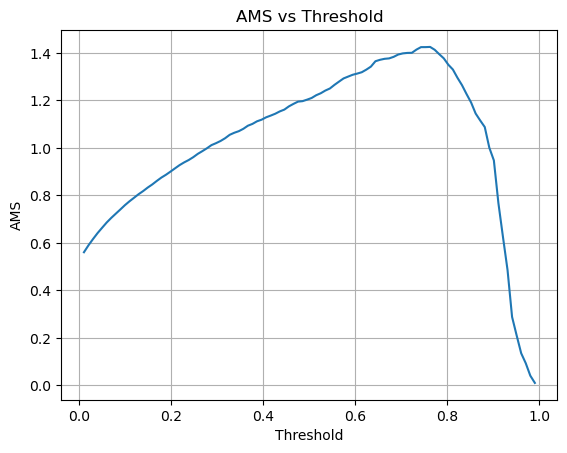

In [42]:
thresholds = np.linspace(0.01, 0.99, 100)
ams_scores = [compute_ams(y_test, y_probs, w_test, threshold=t) for t in thresholds]

plt.plot(thresholds, ams_scores)
plt.xlabel("Threshold")
plt.ylabel("AMS")
plt.title("AMS vs Threshold")
plt.grid(True)
plt.show()

In [43]:
best_index = np.argmax(ams_scores)
best_threshold = thresholds[best_index]
best_ams = ams_scores[best_index]

print(f"Best AMS: {best_ams:.4f} at threshold = {best_threshold:.3f}")

Best AMS: 1.4248 at threshold = 0.762


**Here we can see that the sNN is more confident than the dNN, with a higher threshold**

In [44]:
y_final_preds = (y_probs > best_threshold).astype(int)

In [45]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Accuracy:", accuracy_score(y_test, y_final_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_final_preds))
print(classification_report(y_test, y_final_preds))

Accuracy: 0.77218
Confusion Matrix:
 [[32112   755]
 [10636  6497]]
              precision    recall  f1-score   support

         0.0       0.75      0.98      0.85     32867
         1.0       0.90      0.38      0.53     17133

    accuracy                           0.77     50000
   macro avg       0.82      0.68      0.69     50000
weighted avg       0.80      0.77      0.74     50000

